# Approach I: Universal time-independent prediction

+ ***No need for previous analyses, just time of gestation***

> ***Data wrangling:***

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
%matplotlib inline
matplotlib.style.use('ggplot')

# Hate pandas warnings
import warnings
warnings.simplefilter('ignore')

In [2]:
# Import sklearn stuff
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

C:\Users\Pedro\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Load data
data = pd.read_csv('training_ultrasound.csv')

# Filter agedays < 0 (pre-birth weight)
data = data[data['AGEDAYS']<0]

# Filter na's
ultrasound = ['HCIRCM', 'ABCIRCM', 'BPDCM', 'FEMURCM']
data.dropna(subset=ultrasound+['BWT_40'], inplace=True)

# Change parity
data.loc[data['STUDYID']==2, 'PARITY'] = data.loc[data['STUDYID']==2, 'PARITY'] + 1

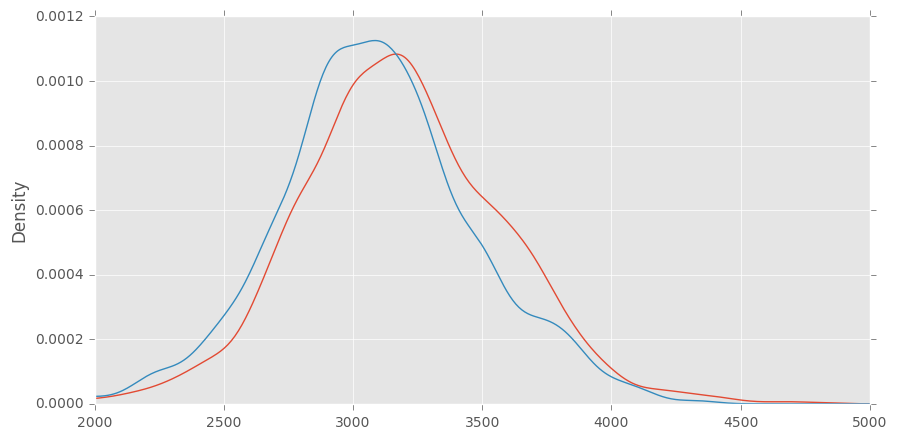

In [4]:
# Sex plot
fig, ax = plt.subplots(1,1, figsize=(10,5))
for sex in ['Male', 'Female']:
    data.loc[data['SEX']==sex, 'BIRTHWT'].plot(kind='kde')
    ax.set_xlim((2000, 5000))

+ Sex doesn't seem important, but we'll see afterwards

> ***Model:***

In [5]:
# Select basic vars, dropnas
df_model = data[['GAGEDAYS', 'SEXN', 'PARITY', 'GRAVIDA', 'BWT_40'] + ultrasound]
df_model.fillna(1, inplace=True) # Onl
df_model['SEXN'] = df_model['SEXN'].replace([1,2], [0,1])

In [6]:
# Feature engineering
df_model['past_gest'] = df_model['PARITY'] - df_model['GRAVIDA']
df_model['head'] = df_model['HCIRCM'] / df_model['BPDCM']
df_model['vol'] = (df_model['BPDCM'])**3
df_model['cilinder'] =(df_model['ABCIRCM']**2)*df_model['FEMURCM']
df_model['four'] = df_model['HCIRCM']*df_model['BPDCM']*df_model['ABCIRCM']*df_model['FEMURCM']
df_model['femur_temp'] = (df_model['FEMURCM']/df_model['GAGEDAYS'])
df_model['femur/abd'] = df_model['FEMURCM']/df_model['ABCIRCM']
df_model['head*femur'] = df_model['head']*df_model['FEMURCM']
df_model['BWT_40'] = np.log(1 + df_model['BWT_40'])

+ ***We don't need to scale features, since we are using boosted trees***

In [7]:
# Training df 
X = df_model.drop('BWT_40', axis=1).values
Y = df_model['BWT_40'].values

# Split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [8]:
# Easy boosted trees (just pure scikit)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cross_validation import cross_val_score
rf = RandomForestRegressor(n_estimators=500, n_jobs=-1, max_depth=15, max_features='sqrt')
gb = GradientBoostingRegressor(loss='ls', learning_rate=0.03, n_estimators=1000, max_depth=10)

# Cross val score

cv_mean_abs_error = np.absolute(cross_val_score(gb, x_train, y_train, n_jobs=-1, scoring='mean_absolute_error', ))
cv_mean_sqrd_error = cv_mean_abs_error**2
print('Mean sqrd error: ', cv_mean_sqrd_error)
print('Mean abs error: ' , cv_mean_abs_error)

Mean sqrd error:  [ 0.00282023  0.00293484  0.00287162]
Mean abs error:  [ 0.05310581  0.05417412  0.05358753]


In [9]:
# Train test
gb.fit(x_train, y_train);

# Test error
from sklearn.metrics import mean_absolute_error
print('Test mean abs_error: ', mean_absolute_error(y_test, gb.predict(x_test)))
print('Test mean sqrd_error: ', mean_absolute_error(y_test, gb.predict(x_test))**2)

# Plot pct errors
y_pred = gb.predict(x_test)
abs_error = np.absolute(y_test - y_pred)
pct_error = abs_error / y_test

Test mean abs_error:  0.0504762846559
Test mean sqrd_error:  0.00254785531266


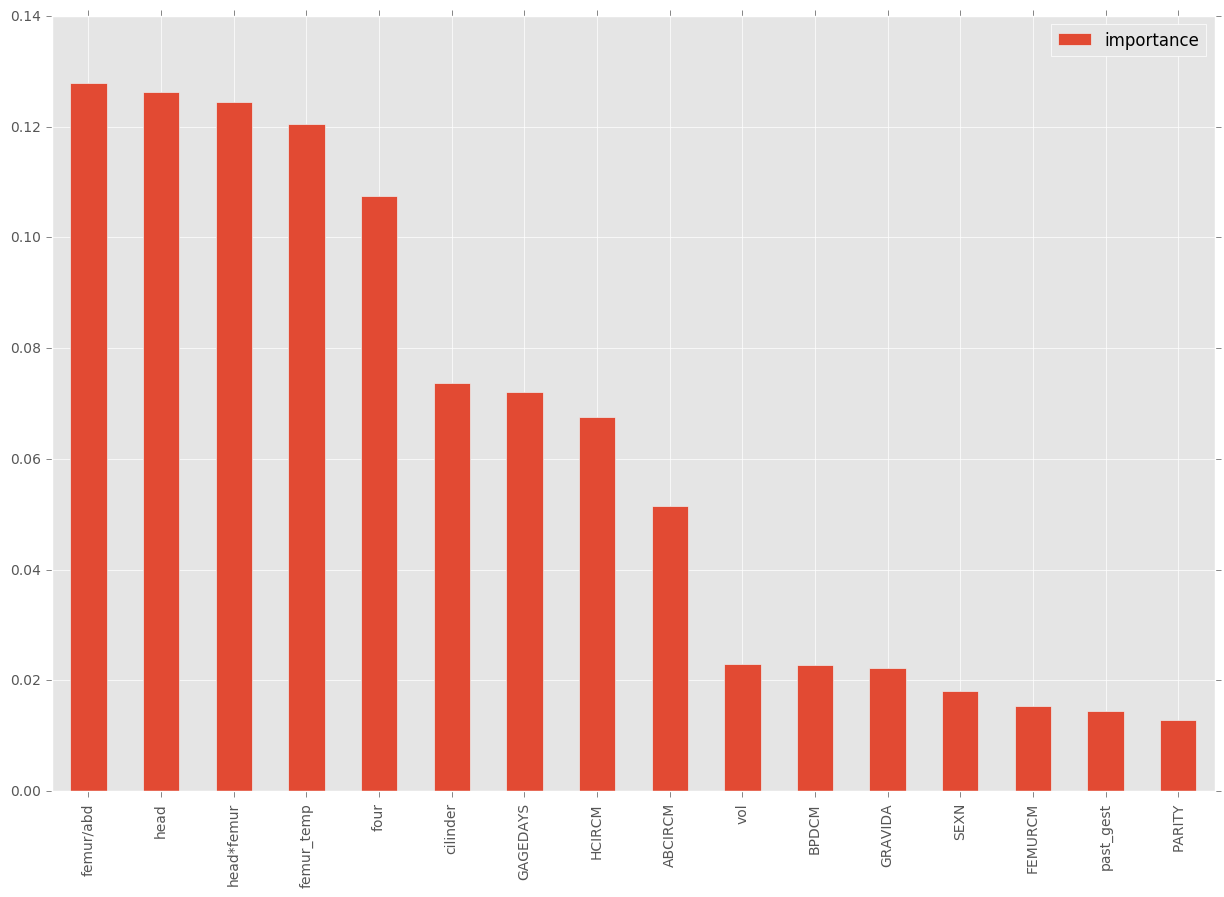

In [10]:
# Variable importances
pd.DataFrame(gb.feature_importances_, columns=['importance'],
             index=df_model.drop('BWT_40', axis=1).columns).sort_values('importance', ascending=False).plot(kind='bar', 
                                                                                           figsize=(15,10));

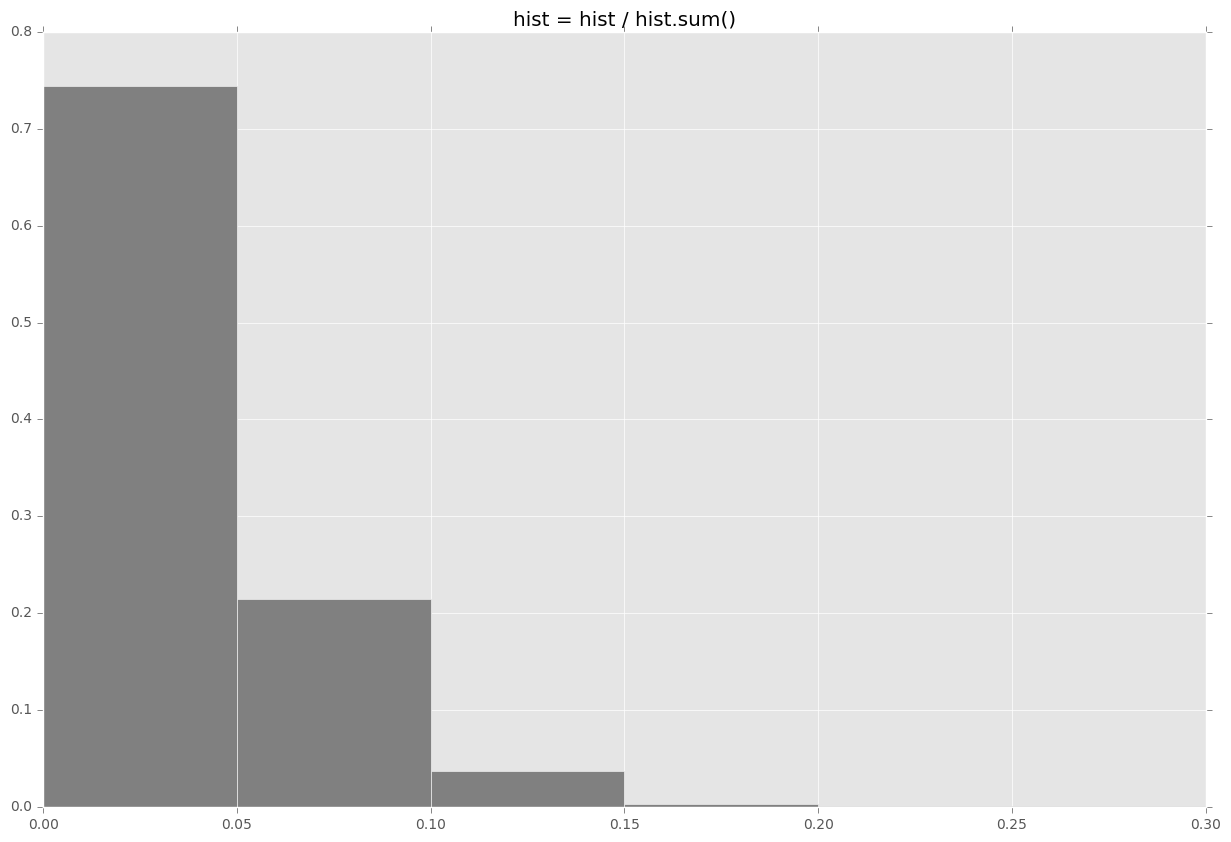

In [11]:
# Percent errors binned
fig, ax = plt.subplots(figsize=(15,10))
hist, bins = np.histogram(pct_error, bins=[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='grey')

ax.set_title('normed=True')
ax.set_title('hist = hist / hist.sum()');

*** Now we obtain the true errors ***

$$Y_\text{true} = log(1 + w_\text{true}) \hspace{1cm} e^{Y_\text{true}} =1 + w_\text{true}\\$$
$$Y_\text{pred} = log(1+w_\text{pred})\hspace{1cm} e^{Y_\text{pred}} =1 + w_\text{pred}\\$$

$$|w_\text{true}-w_\text{pred}| = |(e^\text{true}-1) - (e^\text{pred}-1)|$$

In [12]:
# Compute true errors
w_true = np.exp(y_test) - 1
w_pred = np.exp(y_pred) - 1
abs_error_2 = np.absolute(w_true - w_pred)
mean_abs_error_2 = abs_error_2.mean()
mean_squared_error_2 = (mean_abs_error_2**2)
pct_error_2 = abs_error_2 / w_true

# true test set errors
mean_abs_error_2, mean_squared_error_2

(0.21506350973158811, 0.046252313218068893)

In [13]:
# Mean absolute percentage error
print('Mean absolute percentage test error: %0.4f' % pct_error_2.mean())

Mean absolute percentage test error: 0.0660


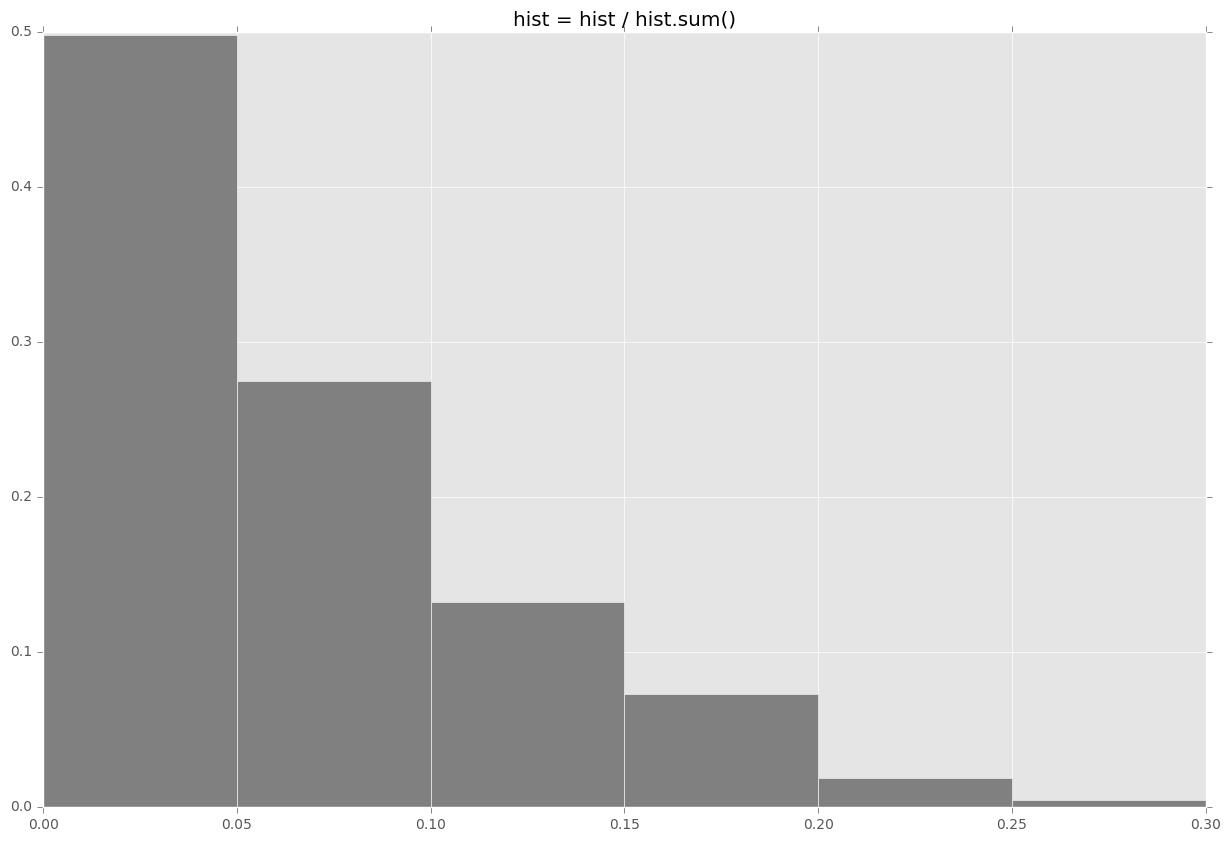

In [14]:
# Plot new errors
fig, ax = plt.subplots(figsize=(15,10))
hist, bins = np.histogram(pct_error_2, bins=[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='grey')

ax.set_title('normed=True')
ax.set_title('hist = hist / hist.sum()');